# Recover cell cycle in mESC

Here we use the mESC dataset. For simplicity we have converted the dataset into TPM.
The original count data is available at ArrayExpress: [E-MTAB-2805](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-2805/). Tools to transform data are also provided and explained in the following sections.

## Import necessary packages

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import sys

import pandas as pd
import numpy as np
import pickle as pkl
import sklearn as skl
import sklearn.preprocessing

import matplotlib as mpl

import matplotlib.pyplot as plt

Warning information from TensorFlow may occur. It doesn't matter.

In [3]:
import cyclum
from cyclum import writer

/home/shaoheng/.conda/envs/tensorflow-gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
input_file_mask = 'data/mESC/mesc-tpm'
output_file_mask = './results/mESC_original/mesc-tpm'

## Read data
Here we have label, so we load both. However, the label is not used until evaluation.

In [5]:
def preprocess(input_file_mask):
    """
    Read in data and perform log transform (log2(x+1)), centering (mean = 1) and scaling (sd = 1).
    """
    tpm = writer.read_df_from_binary(input_file_mask).T
    sttpm = pd.DataFrame(data=skl.preprocessing.scale(np.log2(tpm.values + 1)), index=tpm.index, columns=tpm.columns)
    
    label = pd.read_csv(input_file_mask + '-label.txt', sep="\t", index_col=0).T
    return sttpm, label

sttpm, label = preprocess(input_file_mask)

There is no convention whether cells should be columns or rows. Here we require cells to be rows.

In [6]:
sttpm.head()

Gnai3      Pbsn     Cdc45       H19     Scml2  Apoh  \
G1_cell1_count -0.411123 -0.059028 -0.099416  5.385822 -0.691219   0.0   
G1_cell2_count -0.180800 -0.059028  0.777223 -0.165725 -0.820206   0.0   
G1_cell3_count -1.409101 -0.059028 -1.218187 -0.165725 -0.820206   0.0   
G1_cell4_count -1.867558 -0.059028  0.923695 -0.165725 -0.820206   0.0   
G1_cell5_count -1.646290 -0.059028  0.001887 -0.165725 -0.820206   0.0   

                    Narf      Cav2      Klf6     Scmh1      ...        \
G1_cell1_count -0.690715 -0.059028 -1.051909 -0.350978      ...         
G1_cell2_count  0.362341 -0.059028  1.458881  0.207421      ...         
G1_cell3_count -0.690715 -0.059028 -1.271394 -0.657735      ...         
G1_cell4_count  0.903266 -0.059028  1.430708 -0.657735      ...         
G1_cell5_count -0.690715 -0.059028 -0.811233 -0.657735      ...         

                RP23-345J21.2  AC121960.1  AC136147.1  AC122013.1  AC132389.1  \
G1_cell1_count      -0.146722         0.0   -0.079577   -0.374972   -0.824399   
G1_cell2_count      -0.146722         0.0   -0.079577   -0.374972   -0.824399   
G1_cell3_count       2.593349         0.0   -0.079577   -0.374972   -0.592938   
G1_cell4_count      -0.146722         0.0   -0.079577   -0.374972    2.938898   
G1_cell5_count      -0.146722         0.0   -0.079577   -0.374972   -0.824399   

                 Gm11392  AC160109.2  AC154675.1  AC156980.1  RP23-429I18.1  
G1_cell1_count -0.059028   -0.079861         0.0   -0.144843       0.090295  
G1_cell2_count -0.059028   -0.079861         0.0   -0.144843      -1.271033  
G1_cell3_count -0.059028   -0.079861         0.0   -0.144843      -1.271033  
G1_cell4_count -0.059028   -0.079861         0.0   -0.144843      -1.271033  
G1_cell5_count -0.059028   -0.079861         0.0   -0.144843      -0.111558  

[5 rows x 38293 columns]

In [7]:
label.head()

stage
G1_cell1_count  g0/g1
G1_cell2_count  g0/g1
G1_cell3_count  g0/g1
G1_cell4_count  g0/g1
G1_cell5_count  g0/g1

## Set up the model and fit the model

Fitting the model may take some time. Using a GTX 960M GPU it takes 6 minutes.

In [8]:
model = cyclum.core.PreloadCyclum2(sttpm.values)

<tf.Variable 'encoder0/layer0/W:0' shape=(38293, 30) dtype=float32_ref>
<tf.Variable 'encoder0/layer1/W:0' shape=(30, 20) dtype=float32_ref>
<tf.Variable 'encoder0/output/W:0' shape=(20, 1) dtype=float32_ref>
<tf.Variable 'encoder1/output/W:0' shape=(38293, 1) dtype=float32_ref>
<tf.Variable 'decoder1/output/W:0' shape=(1, 38293) dtype=float32_ref>


In [9]:
pseudotime, rotation = model.train()

pretrain burnin
step  2000: loss [0.6328813, 1890222.0, 120670.266] time 11.93
pretrain train
step  2000: loss [0.63267934, 1890225.4, 120666.53] time 9.97
step  4000: loss [0.6324089, 1890222.0, 120666.75] time 8.07
midtrain burnin
step  2000: loss [0.6324089, 13729.129, 62122.69] time 31.57
midtrain train
step  2000: loss [0.6324089, 13718.6875, 62122.684] time 32.91
step  4000: loss [0.6324089, 13718.685, 62122.684] time 29.18
finaltrain train
step  2000: loss [0.6441994, 12986.716, 33158.242] time 41.75
step  4000: loss [0.6452586, 12985.151, 17336.076] time 38.43
step  6000: loss [0.6454595, 12981.982, 8525.44] time 38.47
finaltrain refine
step  2000: loss [0.6459814, 12981.376, 6735.352] time 41.93
step  4000: loss [0.64787185, 12981.083, 5346.3447] time 38.42
step  6000: loss [0.6474729, 12980.591, 4230.1133] time 38.48
step  8000: loss [0.6471928, 12980.596, 3329.9866] time 39.59
step 10000: loss [0.64715797, 12980.599, 2607.2913] time 39.46
Full time 441.08


In [10]:
pseudotime

array([[-9.99997437e-01, -1.25285978e+01],
       [-9.99993086e-01, -7.60270071e+00],
       [-9.98291016e-01,  6.90062380e+00],
       [-9.99987245e-01, -2.78075142e+01],
       [-9.99999225e-01, -2.85076408e+01],
       [-9.98254418e-01,  1.06687880e+01],
       [-9.99996185e-01,  1.53862441e+00],
       [-9.98015940e-01,  1.11663265e+01],
       [-9.99729753e-01,  2.22984295e+01],
       [-2.03480914e-01,  1.23849926e+01],
       [-9.99966502e-01,  3.35057712e+00],
       [-9.99997795e-01, -1.40906134e+01],
       [-8.17084789e-01,  2.55291824e+01],
       [-9.99983072e-01, -2.69362307e+00],
       [-9.99979019e-01,  1.83463631e+01],
       [-9.99884784e-01,  1.86223373e+01],
       [-9.97905850e-01,  1.84945908e+01],
       [-9.99997973e-01, -1.32733603e+01],
       [-9.99702454e-01,  8.14664078e+00],
       [-9.99998093e-01,  2.83003306e+00],
       [ 9.98380005e-01,  2.98412304e+01],
       [-9.95011449e-01,  2.51617012e+01],
       [-9.99586821e-01,  1.39927025e+01],
       [ 9.

In [11]:
rotation

array([[-2.2024615e-03, -2.8028332e-03, -1.6145920e-03, ...,
         0.0000000e+00,  2.8895540e-03,  4.9248934e-03],
       [-2.3664348e-02,  2.1950809e-02, -5.0180640e-02, ...,
        -1.3906082e-38,  5.5273380e-02,  4.7567181e-02],
       [ 2.5883866e-02, -1.9142484e-02,  5.1777992e-02, ...,
        -1.9330769e-37, -5.8169167e-02, -5.2490093e-02]], dtype=float32)

## Illustrations
We illustrate the results on a circle, to show its circular nature. 
There is virtually no start and end of the circle.
Red, green and blue represents G0/G1, S and G2/M phase respectively.
The inner lines represents single cells. The cells spread across the
The areas outside

In [12]:
import cyclum.illustration

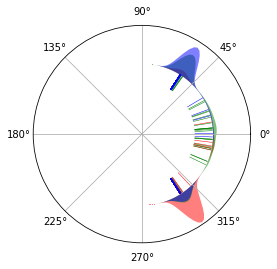

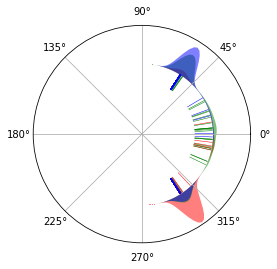

In [13]:
color_map = {'stage': {"g0/g1": "red", "s": "green", "g2/m": "blue"},
                 'subcluster': {"intact": "cyan", "perturbed": "violet"}}
cyclum.illustration.plot_round_distr_color(pseudotime[:, 0], label['stage'], color_map['stage'])